# An Analysis of the Server Room Power Consumption
## 1. Import Data
First, let's use the pandas library to import the data and store it. It is quite obvious that the first sample is a fluke, and was thus ignored.

In [484]:
## Import Raw Data, convert to_datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp

dl1 = pd.read_csv("../data/DL1March_May_24.csv").drop(columns="No.").drop(0)
dl3 = pd.read_csv("../data/DL3March_May_24.csv").drop(columns="No.").drop(0)

dl1["Date/Time"] = pd.to_datetime(dl1["Date/Time"], format='%d/%m/%Y %H:%M')
dl3["Date/Time"] = pd.to_datetime(dl3["Date/Time"], format='%d/%m/%Y %H:%M')

# print(dl1.head())
# it is quite obvious that the first row of values are outliers, so they are removed

### Key Analyses to Perform
1. **Time-Series Analysis**
    1. Energy Consumption Over Time:
        - Objective: Identify overall trends in energy usage. Are there periods of high consumption? How does energy use vary by day or hour?
        - Analysis: Plot energy consumption over time. Break down by day, week, and month to identify patterns (e.g., higher usage during workdays vs. weekends).
    2. Instantaneous Power and Current:
        - Objective: Examine how power consumption and current vary over time.
        - Analysis: Plot these variables against time. Look for spikes or irregularities that could indicate issues with equipment or unusual activity.
    3. Cost Analysis:
        - Objective: Correlate energy consumption with costs to identify cost-saving opportunities.
        - Analysis: Plot cost versus energy consumption over time. Look for periods where costs may be disproportionately high compared to energy use.

2. **Efficiency Analysis**
    1. Power Factor Analysis:
        - Objective: Assess the efficiency of energy use.
        - Analysis: Evaluate the power factor over time. A lower power factor suggests inefficiency, possibly due to the presence of inductive loads like motors or transformers. Identify periods of low power factor and investigate causes.
    2. Correlation Between Variables:
        - Objective: Understand relationships between power consumption, current, and power factor.
        - Analysis: Use scatter plots or correlation matrices to explore how these variables relate. For example, check if lower power factors correlate with higher currents or power usage.

3. **Peak Demand and Load Analysis**
    1. Identify Peak Power Consumption:
        - Objective: Determine when peak demands occur, which could impact energy costs and infrastructure stress.
        - Analysis: Find the time periods with the highest instantaneous power consumption. Analyze whether these peaks align with specific activities or times of day.
    2. Load Distribution:
        - Objective: Ensure that the electrical load is balanced and within safe operational limits.
        - Analysis: Analyze the distribution of current through the wires over time. Identify any periods where the load is unusually high, indicating potential risks.


check relationship power factor / current / power

## 2. Time-Series Analysis
This section will consist of plotting every data point we have in time in order to establish a relationship between periods of the year and our variables.

Let's only consider DL1 for now: both datasets we have so far are only sampling servers. Now, time to plot the raw data.
### Raw Data Plotting

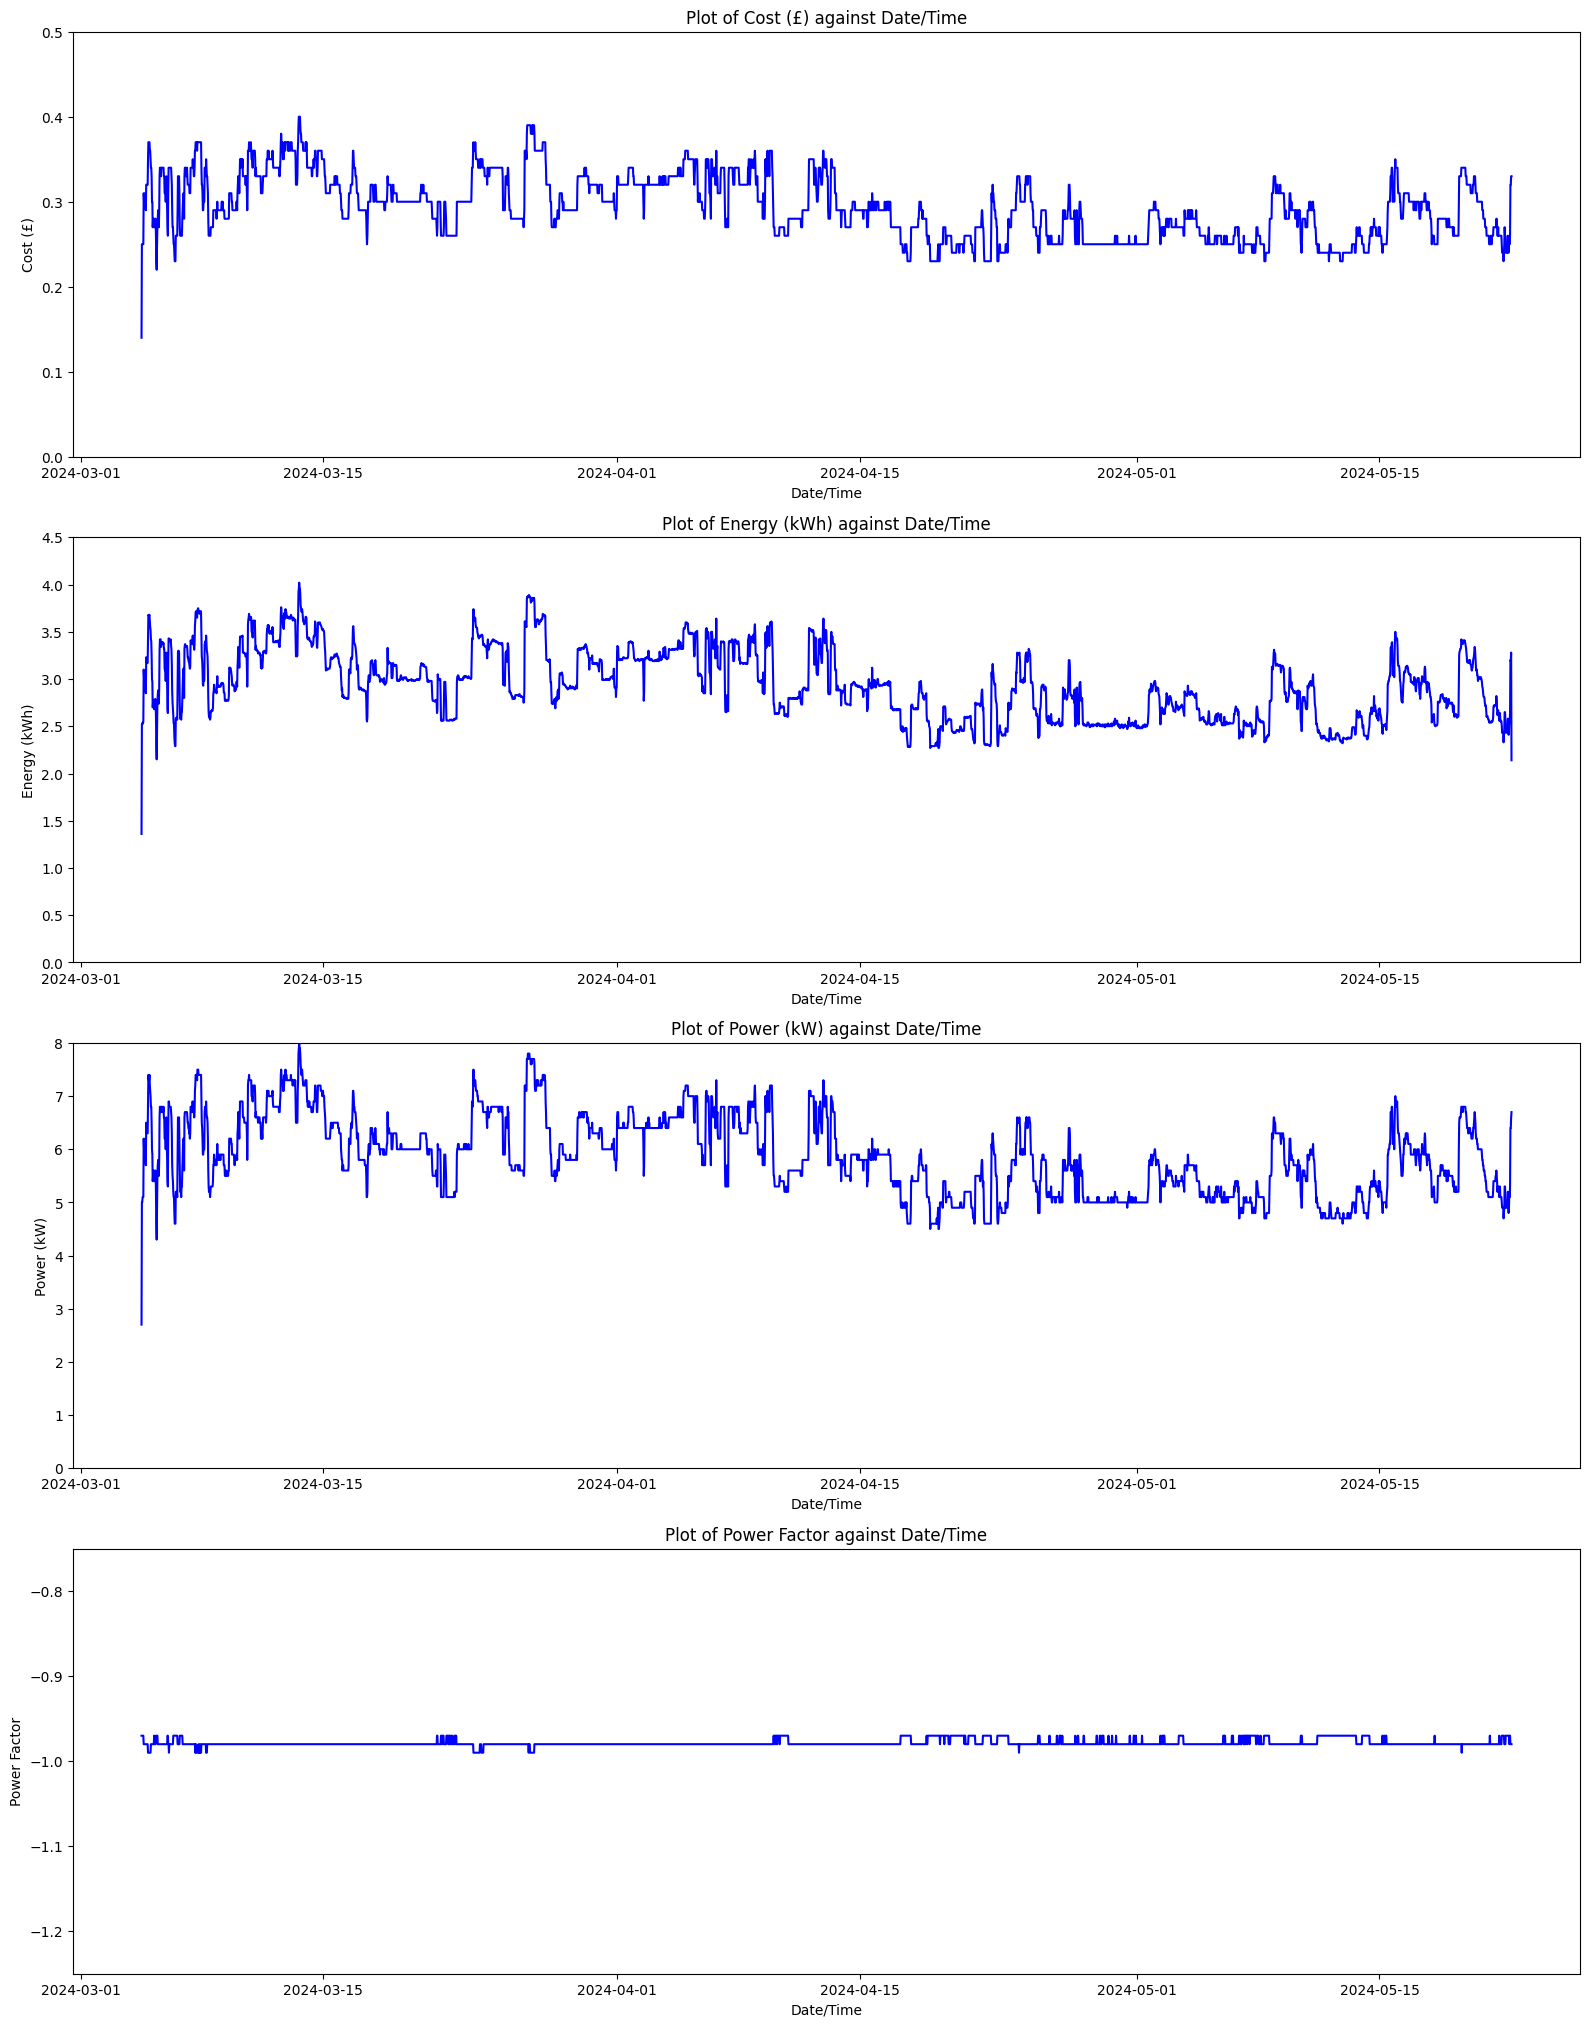

In [485]:
plt.figure(figsize=(16, 5*5))

headers = dl1.columns.values.tolist()
i = 0
for i in range(1, 5):
    match i:
        case 1: vertical_limits = (0, 0.5)
        case 2: vertical_limits = (0, 4.5)
        case 3: vertical_limits = (0, 8)
        case 4: vertical_limits = (-1.25, -0.75)
        case 5: vertical_limits = (10, 40)
    plt.subplot(5, 1, i)
    plt.plot(dl1["Date/Time"], dl1[headers[i]], color='b')
    plt.ylim(vertical_limits)
    plt.xlabel("Date/Time")
    plt.ylabel(headers[i])
    plt.title("Plot of " + headers[i] + " against Date/Time")
    
plt.tight_layout()
plt.show()

Note that most of these are very similar, as proved by the correlation matrix below, where nearly all variables have a correlation coefficient of 1.
This also makes sense intuitively: cost is directly proportional to energy consumed, as per the energy provider; the sampling time is constant at twice per hour, so the energy will also be linearly linked to the power; and finally, assuming the supply voltage stays constant throughout, power and current are also directly proportional to one another. Power factor is separate, but its stableness indicates that our assumption about stable voltage supply is accurate.

In [486]:
print(dl1.drop(columns=["Date/Time"]).corr())

                  Cost (£)  Energy (kWh)  Power (kW)  Power Factor  \
Cost (£)          1.000000      0.995811    0.995801     -0.582129   
Energy (kWh)      0.995811      1.000000    0.997802     -0.585075   
Power (kW)        0.995801      0.997802    1.000000     -0.585427   
Power Factor     -0.582129     -0.585075   -0.585427      1.000000   
Current 1 (amps)  0.994282      0.995574    0.996145     -0.581830   

                  Current 1 (amps)  
Cost (£)                  0.994282  
Energy (kWh)              0.995574  
Power (kW)                0.996145  
Power Factor             -0.581830  
Current 1 (amps)          1.000000  


For this reason, only the power will be plotted in further figures, for ease of readability.

In [487]:
HEADER = "Power (kW)" # DO NOT MODIFY


### Histogram(s)
It is unkown what type of distribution this power consumption obeys. The hypothesis is that, as a natural random event, it follows a normal distribution. Let's explore this further.

Text(0.5, 1.0, 'Histogram of Power (kW) (removed first sample for clarity)')

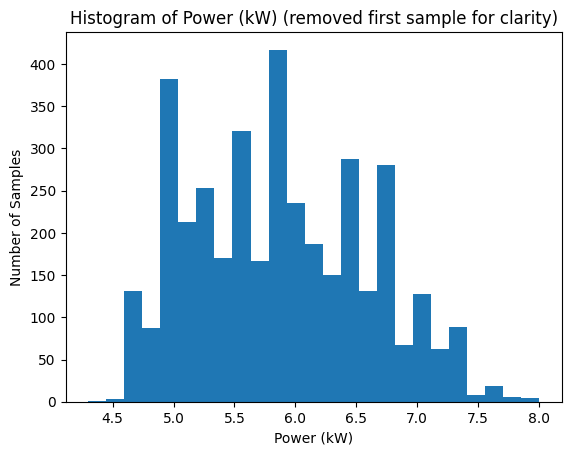

In [488]:
plt.figure()
plt.hist(dl1[HEADER][1:], bins=25)
plt.xlabel(HEADER)
plt.ylabel("Number of Samples")
plt.title("Histogram of " + HEADER + " (removed first sample for clarity)")

### Important Dates
During these times, there were bank holidays, campus closure times, as well as a switch from term time to holiday time. As the servers are mostly used by MsC and PhD students, usually overnight, it is expected that the power consumption over that time remains relatively constant. Here, we will distiguish between power consumption on weekends, bank holidays, term time, and campus closure.

To distinguish between which variable is being analysed, a HEADER variable will be defined. It must not be touched at all times.

#### Bank Holidays & Campus Closure
The dates were pulled manually from the official imperial website.

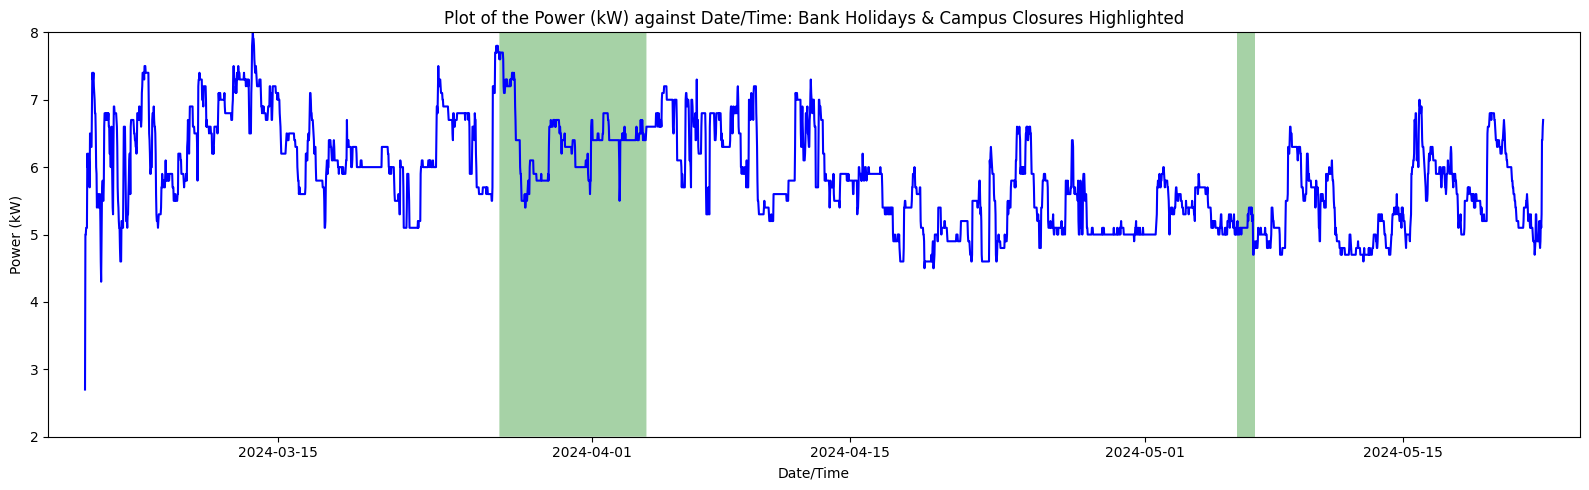

In [489]:
# bank holidays + campus closure
bank_holidays = pd.to_datetime(["27/03/2024", "28/03/2024", "29/03/2024", "30/03/2024", "31/03/2024", "01/04/2024", "02/04/2024", "03/04/2024", 
                 "06/05/2024", "27/05/2024", "26/08/2024"], format='%d/%m/%Y')

# initialize figure
plt.figure(figsize=(16, 5))
vertical_limits = (2, 8)

plt.plot(dl1["Date/Time"], dl1[HEADER], color='b')
plt.fill_between(dl1["Date/Time"], vertical_limits[0], vertical_limits[1], step='post',
                 where=[time.normalize() in bank_holidays for time in dl1["Date/Time"]], 
                 facecolor='g', alpha=0.35)
plt.ylim(vertical_limits)
plt.xlim(dl1["Date/Time"].iloc[0] - pd.Timedelta(days=2), dl1["Date/Time"].iloc[-1] + pd.Timedelta(days=2))
plt.xlabel("Date/Time")
plt.ylabel(HEADER)
plt.title("Plot of the " + HEADER + " against Date/Time: Bank Holidays & Campus Closures Highlighted")
    
plt.tight_layout()
plt.show()

#### Term Time
Again, term time dates were pulled from Imperial's official website.

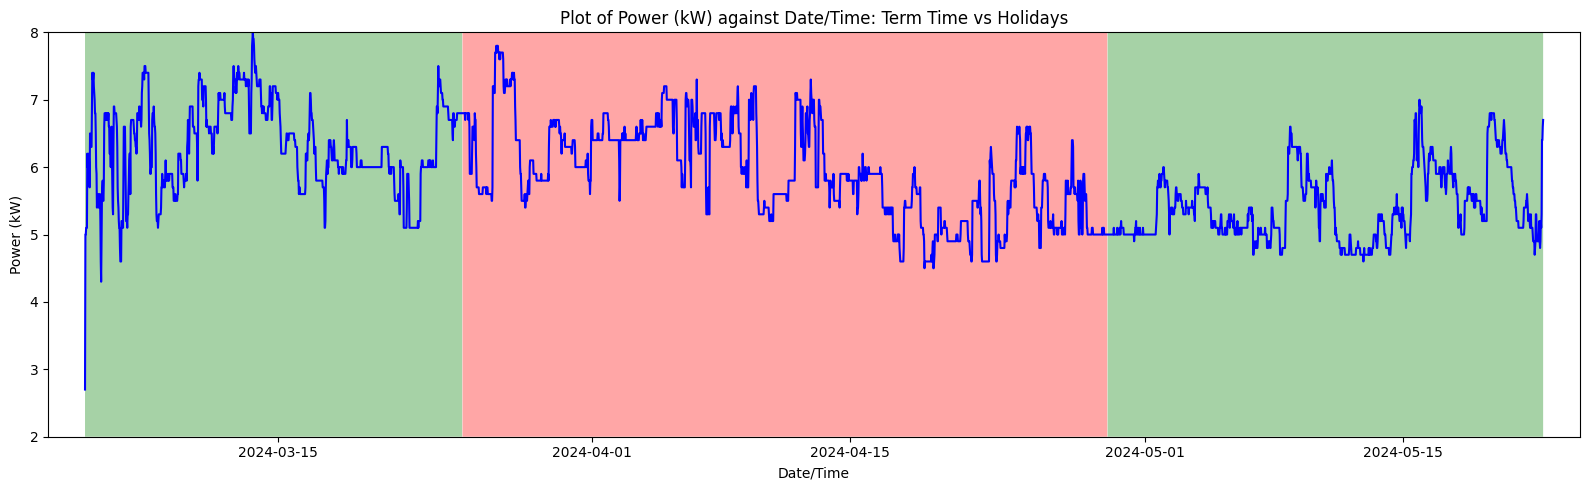

In [490]:
# Term Time relation to power consumption
spring_term = pd.date_range(pd.to_datetime("2024-01-07"), pd.to_datetime("2024-03-24"), freq=pd.Timedelta(days=1))
summer_term = pd.date_range(pd.to_datetime("2024-04-29"), pd.to_datetime("2024-06-30"), freq=pd.Timedelta(days=1))

plt.figure(figsize=(16, 5))
vertical_limits = (2, 8)

plt.plot(dl1["Date/Time"], dl1[HEADER], color='b')
plt.fill_between(dl1["Date/Time"], vertical_limits[0], vertical_limits[1],
                 where=[time.normalize() not in spring_term and time.normalize() not in summer_term for time in dl1["Date/Time"]], 
                 facecolor='r', alpha=0.35)
plt.fill_between(dl1["Date/Time"], vertical_limits[0], vertical_limits[1],
                 where=[time.normalize() in spring_term or time.normalize() in summer_term for time in dl1["Date/Time"]], 
                 facecolor='g', alpha=0.35)
plt.ylim(vertical_limits)
plt.xlim(dl1["Date/Time"].iloc[0] - pd.Timedelta(days=2), dl1["Date/Time"].iloc[-1] + pd.Timedelta(days=2))
plt.xlabel("Date/Time")
plt.ylabel(HEADER)
plt.title("Plot of " + HEADER + " against Date/Time: Term Time vs Holidays")
    
plt.tight_layout()
plt.show()

### Weekends vs Weekdays
Here, we will analyse the difference between weekdays, weekends, both individually and as a group. This will include an analysis for each individual day of the week, taking its expected consumption during the day, as well as taking the expected consumption through the week, though the hourly consumption by day will be explored later 

Mean total Power (kW): 5.872274881516588 kW
Median total Power (kW): 5.8 kW

Mean Weekend Power (kW): 5.802935606060607
Mean Weekdays Power (kW): 5.898978847556528
Mean Power (kW)on Monday: 5.881306715063521
Mean Power (kW)on Tuesday: 5.813541666666667
Mean Power (kW)on Wednesday: 5.94293381037567
Mean Power (kW)on Thursday: 6.030681818181819
Mean Power (kW)on Friday: 5.832386363636363
Mean Power (kW)on Saturday: 5.824053030303031
Mean Power (kW)on Sunday: 5.781818181818182
Median Power (kW)on Monday: 6.0
Median Power (kW)on Tuesday: 5.7
Median Power (kW)on Wednesday: 6.0
Median Power (kW)on Thursday: 5.9
Median Power (kW)on Friday: 5.8
Median Power (kW)on Saturday: 5.7
Median Power (kW)on Sunday: 5.8


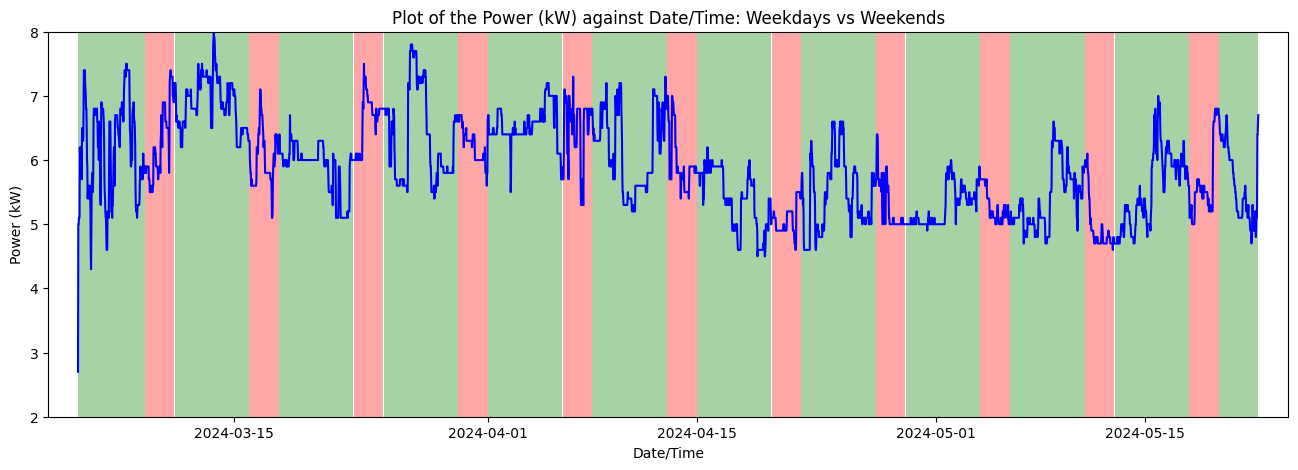

Text(0.5, 1.0, 'Power (kW) for each day of the week')

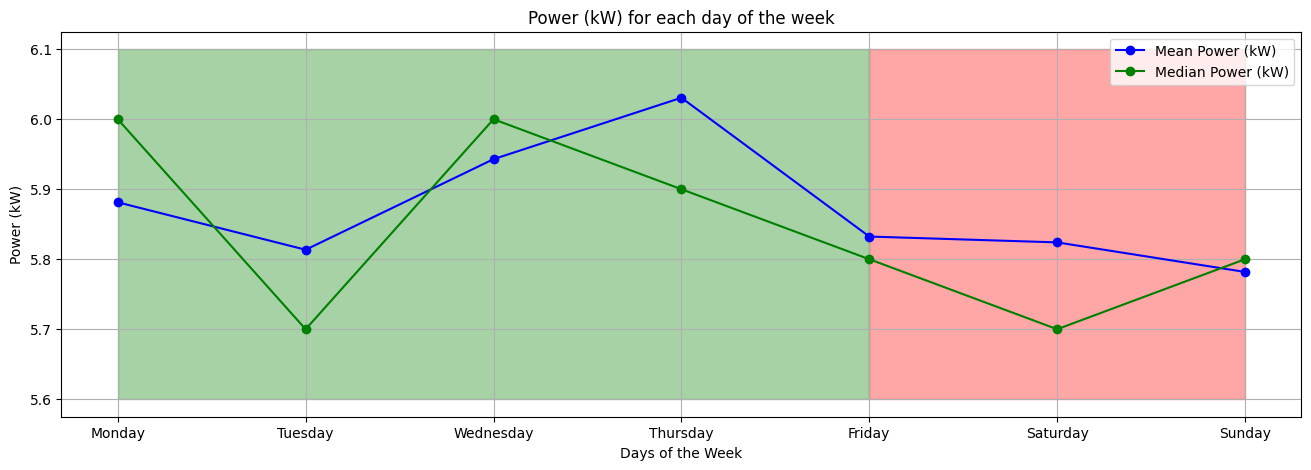

In [491]:
## Mean and median total consumption
print("Mean total " + HEADER + ": " + str(dl1[HEADER].mean()) + " kW")
print("Median total " + HEADER + ": " + str(dl1[HEADER].median()) + " kW\n")

power_days = dl1[HEADER].groupby(dl1["Date/Time"].dt.weekday).apply(list).to_dict()

power_days["Weekend"] = power_days[5] + power_days[6] # 5 == Saturday, 6 == Sunday
power_days["Weekdays"] = power_days[0] + power_days[1] + power_days[2] + power_days[3] + power_days[4]

days_of_the_week = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

print("Mean Weekend " + HEADER + ": " + str(np.mean(power_days['Weekend'])))
print("Mean Weekdays " + HEADER + ": " + str(np.mean(power_days['Weekdays'])))

for i in range(7):
    print("Mean " + HEADER + "on " + days_of_the_week[i] + ": " + str(np.mean(power_days[i])))
for i in range(7):
    print("Median " + HEADER + "on " + days_of_the_week[i] + ": " + str(np.median(power_days[i])))

## FIG1
plt.figure(figsize=(16, 5))
vertical_limits = (2, 8)

plt.plot(dl1["Date/Time"], dl1[HEADER], color='b')
plt.fill_between(dl1["Date/Time"], vertical_limits[0], vertical_limits[1], step='post',
                 where=[time.weekday() == 5 or time.weekday() == 6 for time in dl1["Date/Time"]], 
                 facecolor='r', alpha=0.35)
plt.fill_between(dl1["Date/Time"], vertical_limits[0], vertical_limits[1], step='post',
                 where=[time.weekday() != 5 and time.weekday() != 6 for time in dl1["Date/Time"]], 
                 facecolor='g', alpha=0.35)
plt.ylim(vertical_limits)
plt.xlim(dl1["Date/Time"].iloc[0] - pd.Timedelta(days=2), dl1["Date/Time"].iloc[-1] + pd.Timedelta(days=2))
plt.xlabel("Date/Time")
plt.ylabel(HEADER)
plt.title("Plot of the " + HEADER + " against Date/Time: Weekdays vs Weekends")
    
plt.show()
## FIG2
plt.figure(figsize=(16, 5))
plt.plot([np.mean(power_days[i]) for i in range(7)], color='b', linestyle='-', marker='o', label='Mean ' + HEADER)
plt.plot([np.median(power_days[i]) for i in range(7)], color='g', linestyle='-', marker='o', label='Median ' + HEADER)

plt.fill_between(range(4, 7), 5.6, 6.1, 
                 where=[True]*3, color='r', alpha=0.35)
plt.fill_between(range(5), 5.6, 6.1, 
                 where=[True]*5, color='g', alpha=0.35)

plt.xticks(range(7), days_of_the_week.values())
plt.legend(loc='upper right')
plt.grid()
plt.xlabel("Days of the Week")
plt.ylabel(HEADER)
plt.ylim()
plt.title(HEADER + " for each day of the week")

### Throughout the Day
#### Day vs Night & Working Day vs Night Analysis
Here we will define the day on the clock as 6am-6pm. Alternatively, we will also explore the working day from 9am-5pm, as it could also yield interesting results.

Clock Day Average: 5.803164556962025
Clock Night Average: 5.94071729957806

Working Day Average: 5.800632911392405
Working Night Average: 5.90759493670886


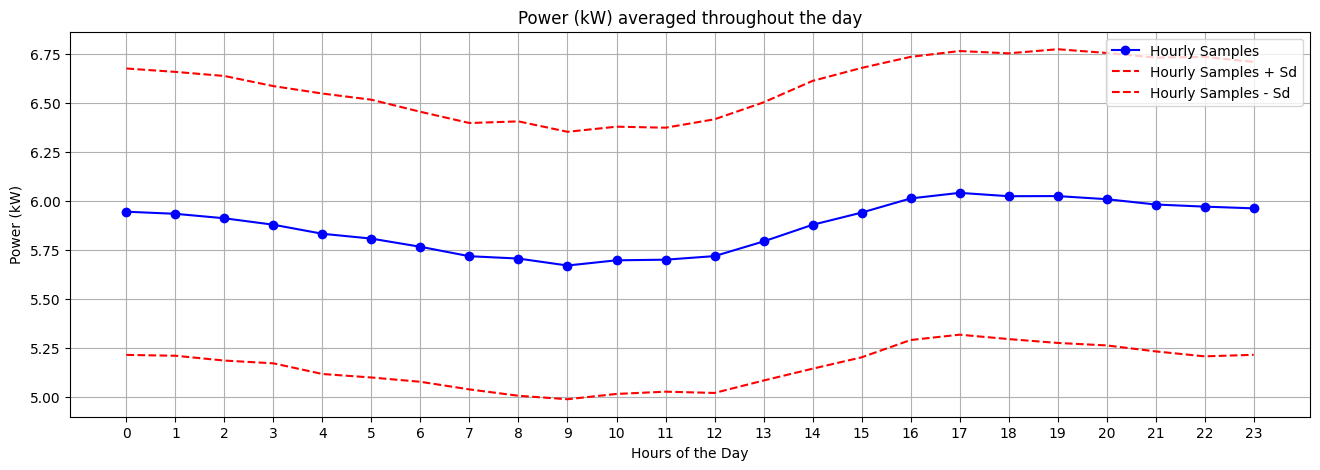

In [492]:
hourly_samples = dl1[HEADER].groupby(dl1["Date/Time"].dt.hour).apply(list).to_dict()
hourly_samples_mean = [np.mean(hourly_samples[i]) for i in range(len(hourly_samples))]
hourly_samples_var = [np.std(hourly_samples[i]) for i in range(len(hourly_samples))]

day_clock = [hourly_samples[i][j] for j in range(len(hourly_samples[i])) for i in range(6, 18)]
day_working = [hourly_samples[i][j] for j in range(len(hourly_samples[i])) for i in range(9, 17)]
night_clock = [hourly_samples[i][j] for j in range(len(hourly_samples[i])) for i in list(range(6))+list(range(18, 24))]
night_working = [hourly_samples[i][j] for j in range(len(hourly_samples[i])) for i in list(range(9))+list(range(17, 24))]

print("Clock Day Average: " + str(np.mean(day_clock)))
print("Clock Night Average: " + str(np.mean(night_clock)))
print("\nWorking Day Average: " + str(np.mean(day_working)))
print("Working Night Average: " + str(np.mean(night_working)))

plt.figure(figsize=(16, 5))
plt.plot(hourly_samples_mean, color='b', linestyle='-', marker='o', label='Hourly Samples')
plt.plot(np.add(hourly_samples_mean, hourly_samples_var), color='r', linestyle='--', label='Hourly Samples + Sd')
plt.plot(np.subtract(hourly_samples_mean, hourly_samples_var), color='r', linestyle='--', label='Hourly Samples - Sd')
plt.xticks(range(24), [str(i) for i in range(24)])
plt.grid()
plt.xlabel("Hours of the Day")
plt.ylabel(HEADER)
plt.title(HEADER + " averaged throughout the day")
plt.legend(loc='upper right')
plt.show()

#### For Each Day of the Week

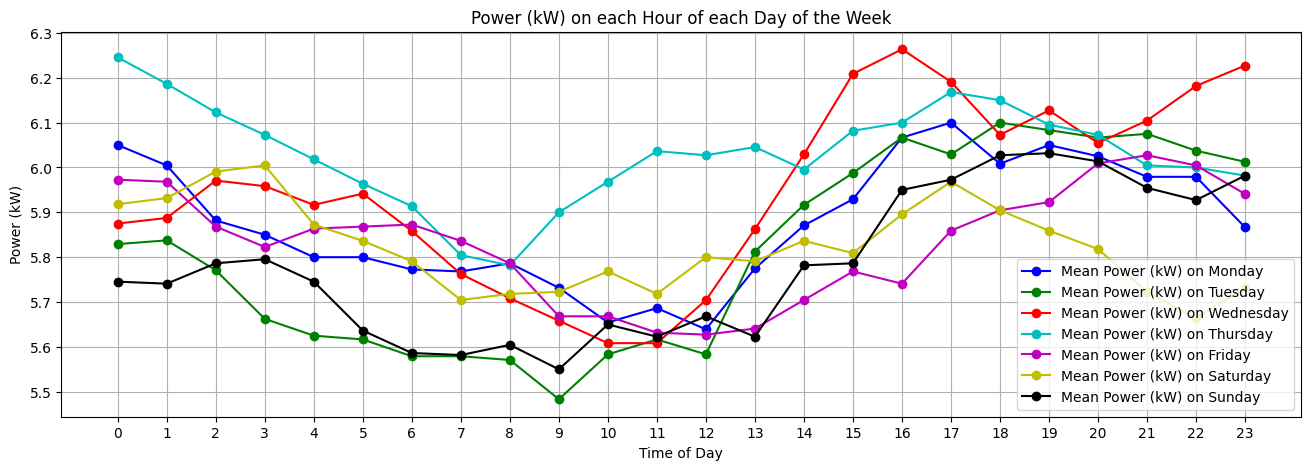

In [493]:
# Group Readings by day of week AND hour using pd.groupby
daily_hourly_samples = dl1.groupby([dl1["Date/Time"].dt.weekday, dl1["Date/Time"].dt.hour])[HEADER].apply(list).to_dict()
days_of_the_week = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
colors = {0: 'b', 1: 'g', 2: 'r', 3: 'c', 4: 'm', 5: 'y', 6: 'k'}

# for individual plots: (VERY time consuming)
# fig, ax = plt.subplots(7, figsize=(16, 20))
# for i in range(7):
#     ax[i].plot([np.mean(daily_hourly_samples[(i, j)]) for j in range(24)], color='b', linestyle='-', marker='o', label='Mean ' + HEADER)
#     # ax[i].plot([np.median(daily_hourly_samples[(i, j)]) for j in range(24)], color='g', linestyle='--', marker='o', label='Median ' + HEADER)
#     ax[i].set_xticks(range(24), [str(i) for i in range(24)])
#     ax[i].set_xlabel(days_of_the_week[i])
#     ax[i].set_ylabel(HEADER)
#     ax[i].set_ylim(5.45, 6.3)
#     ax[i].grid()
#     ax[i].legend(loc='upper right')
# ax[0].set_title(HEADER + " Hourly Average for Each Day of the Week")
# fig.tight_layout()
# plt.show()

plt.figure(figsize=(16, 5))
for i in range(7):
    plt.plot([np.mean(daily_hourly_samples[(i, j)]) for j in range(24)], 
             color=colors[i], linestyle='-', marker='o', label='Mean ' + HEADER + ' on ' + days_of_the_week[i])
plt.xticks(range(24), [str(j) for j in range(24)])
plt.xlabel("Time of Day")
plt.ylabel(HEADER)
plt.legend(loc='lower right')
plt.grid()
plt.title(HEADER + " on each Hour of each Day of the Week")
plt.show()

### Weather Correlation 
Weather data was pulled from
https://meteostat.net/en/place/gb/london?s=03779&t=2024-03-04/2024-05-22

To import the data, the same process as before can be used, taking care to import the date and time as a pandas datetime.
Again, we will plot the raw data.

The correlation between average temperature and power consumption is: 0.13380696844163176


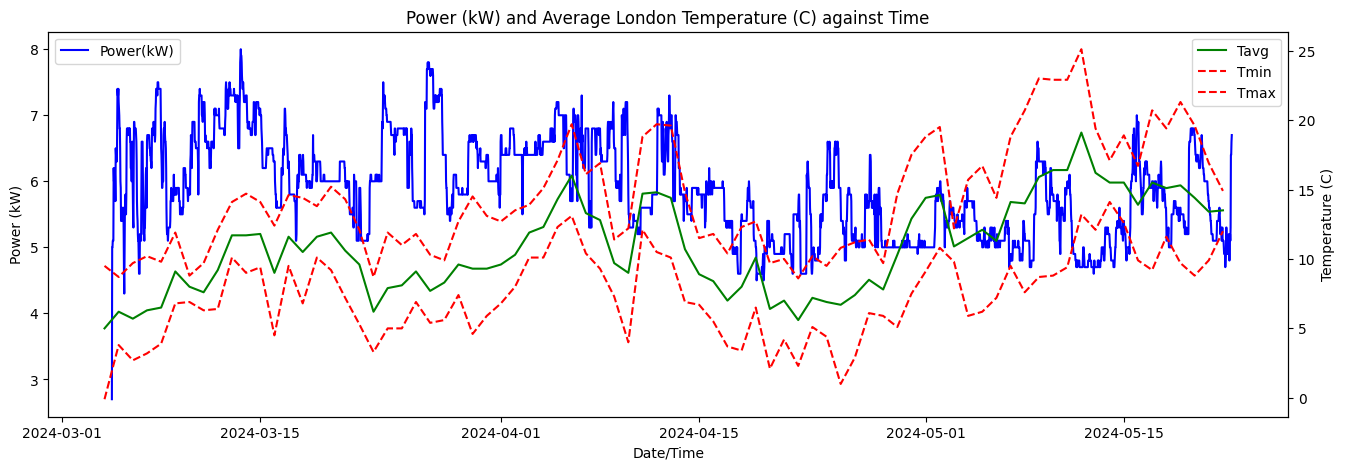

In [494]:
weather = pd.read_csv("../data/London_Daily_Weather.csv").drop(columns=["tsun", "pres"]).fillna(0.0)
weather["date"] = pd.to_datetime(weather["date"], format='%Y-%m-%d')

print("The correlation between average temperature and power consumption is: " + str(dl1[HEADER].corr(weather["tavg"])))

fig, ax = plt.subplots(figsize=(16, 5))
ax.set_xlabel("Date/Time")
ax.set_ylabel(HEADER)
ax.plot(dl1["Date/Time"], dl1[HEADER], color='b', label='Power(kW)', linestyle='-')
plt.legend(loc='upper left')

ax = ax.twinx()

ax.set_ylabel("Temperature (C)")
ax.plot(weather["date"], weather["tavg"], color='g', label='Tavg', linestyle='-')
ax.plot(weather["date"], weather["tmin"], color='r', label='Tmin', linestyle='--')
ax.plot(weather["date"], weather["tmax"], color='r', label='Tmax', linestyle='--')
plt.title("Power (kW) and Average London Temperature (C) against Time")
plt.legend(loc='upper right')
plt.show()

### Rates of Change
It could be interesting to explore rates of change: to see when the servers have an instant increase in activity. This could allow us to prepare for a period of time we can expect an increase / decrease in activity.

Text(0.5, 1.0, 'Derivative of Power against Date/Time')

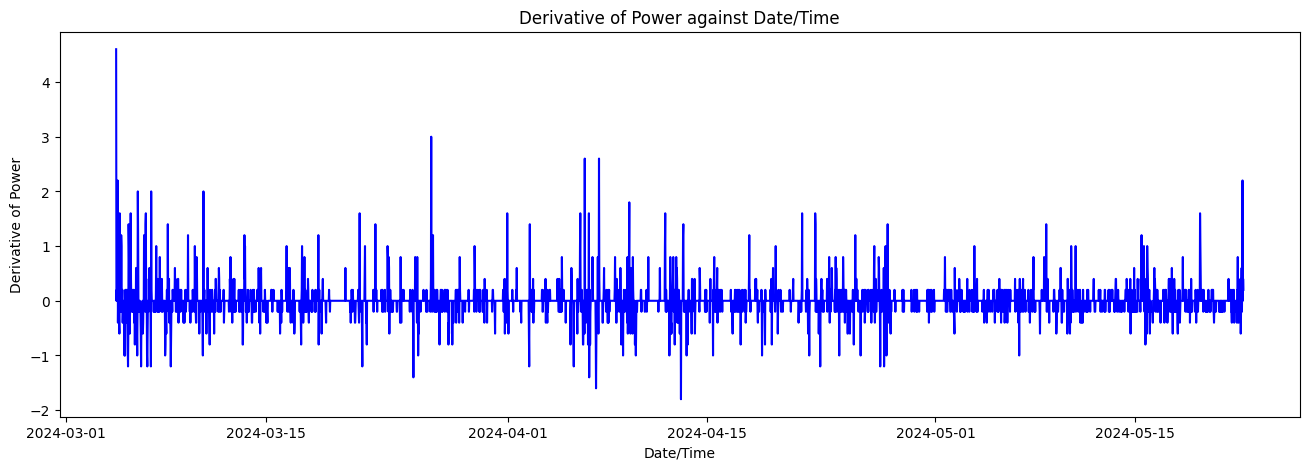

In [495]:
der = [(dl1[HEADER].iloc[i+1] - dl1[HEADER].iloc[i])*2 for i in range(len(dl1)-1)]

plt.figure(figsize=(16, 5))
plt.plot(dl1["Date/Time"][:-1], der, color='b', linestyle='-')
plt.xlabel("Date/Time")
plt.ylabel("Derivative of Power")
plt.title("Derivative of Power against Date/Time")

### Moving Average Analysis

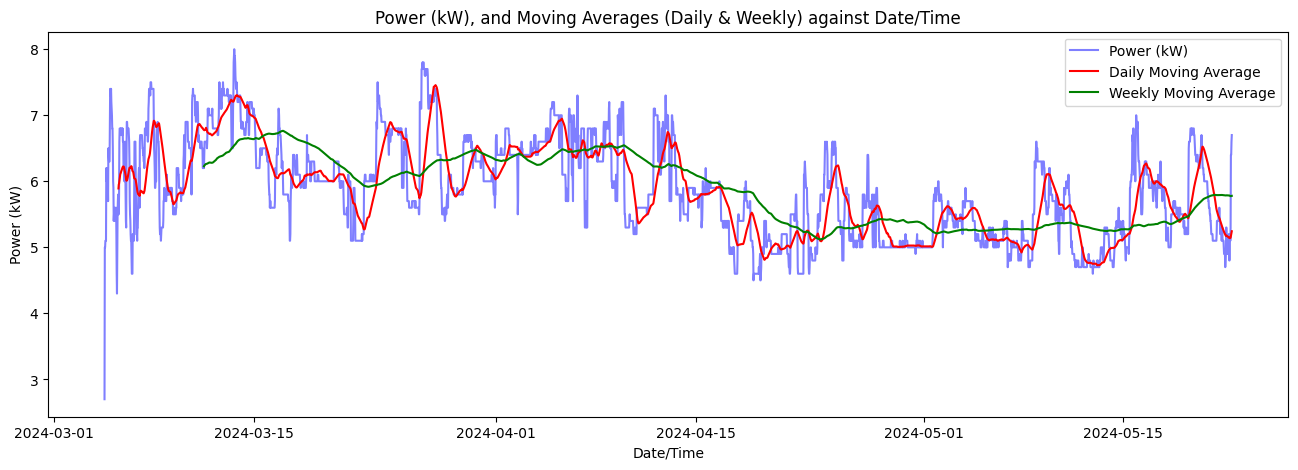

In [496]:
dl1[HEADER + " Av Daily"] = dl1[HEADER].rolling(window=24*2).mean()
dl1[HEADER + " Av Weekly"] = dl1[HEADER].rolling(window=24*2*7).mean()

plt.figure(figsize=(16,5))
plt.plot(dl1["Date/Time"], dl1[HEADER], label=HEADER, color='b', alpha=0.5)
plt.plot(dl1["Date/Time"], dl1[HEADER + " Av Daily"], label='Daily Moving Average', color='r')
plt.plot(dl1["Date/Time"], dl1[HEADER + " Av Weekly"], label='Weekly Moving Average', color='g')
plt.xlabel("Date/Time")
plt.ylabel(HEADER)
plt.legend(loc='upper right')
plt.title(HEADER + ", and Moving Averages (Daily & Weekly) against Date/Time")
plt.show()

In [497]:
print(dl1['Power (kW) Av Daily'].corr(weather['tavg']))

0.4491088864979773


## 3. CPU Usage Correlation
Thanks to Steven Richardson, we have some CPU usage data since August 23rd 2023 to August 14th 2024. We have this data for various servers including: Bermuda, Capsim, Pampas, Saintsaens1, Spinifex, Widor, Messiaen, and Bamboo. A sample was taken every minute or so. In this section, we will explore potential correlations between CPU Usage percentage and power consumption. Unfortunately, we are in the dark as to which server corresponds to which distribution board.

### Import Raw Data
As detailed in correspondance, only Bamboo, Bermuda, Pampas, and Spinifex have the correct data for the correct time frame we are analysing. For this reason, the rest will be omitted for now. We will truncate as necessary.

In [498]:
## Import Data
bamboo = pd.read_csv('../data/CPU-Data-ee-bamboo.csv')
bamboo['now'] = pd.to_datetime(bamboo['now'], utc=True)
bamboo = bamboo.set_index(bamboo['now'], drop=False).truncate(before=pd.Timestamp('2024-03-04 00:00:00+00:00'), 
                                                  after=pd.Timestamp('2024-05-22 00:00:00+00:00')).reset_index(drop=True)

bermuda = pd.read_csv('../data/CPU-Data-ee-bermuda.csv')
bermuda['now'] = pd.to_datetime(bermuda['now'], utc=True)
bermuda = bermuda.set_index(bermuda['now'], drop=False).truncate(before=pd.Timestamp('2024-03-04 00:00:00+00:00'), 
                                                  after=pd.Timestamp('2024-05-22 00:00:00+00:00')).reset_index(drop=True)

# capsim = pd.read_csv('../data/CPU-Data-ee-capsim.csv')
# capsim['now'] = pd.to_datetime(capsim['now'], utc=True)
# capsim = capsim.set_index(capsim['now'], drop=False)

# messiaen = pd.read_csv('../data/CPU-Data-ee-messiaen.csv')
# messiaen['now'] = pd.to_datetime(messiaen['now'], utc=True)
# messiaen = messiaen.set_index(messiaen['now'], drop=False)

pampas = pd.read_csv('../data/CPU-Data-ee-pampas.csv')
pampas['now'] = pd.to_datetime(pampas['now'], utc=True)
pampas = pampas.set_index(pampas['now'], drop=False).truncate(before=pd.Timestamp('2024-03-04 00:00:00+00:00'), 
                                                  after=pd.Timestamp('2024-05-22 00:00:00+00:00')).reset_index(drop=True)

# saintsaens = pd.read_csv('../data/CPU-Data-ee-saintsaens1.csv')
# saintsaens['now'] = pd.to_datetime(saintsaens['now'], utc=True)
# saintsaens = saintsaens.set_index(saintsaens['now'], drop=False)

spinifex = pd.read_csv('../data/CPU-Data-ee-spinifex.csv')
spinifex['now'] = pd.to_datetime(spinifex['now'], utc=True)
spinifex = spinifex.set_index(spinifex['now'], drop=False).truncate(before=pd.Timestamp('2024-03-04 00:00:00+00:00'), 
                                                  after=pd.Timestamp('2024-05-22 00:00:00+00:00')).reset_index(drop=True)

# widor = pd.read_csv('../data/CPU-Data-ee-widor.csv')
# widor['now'] = pd.to_datetime(widor['now'], utc=True)
# widor = widor.set_index(widor['now'], drop=True)

## To Truncate: add .truncate(before=pd.Timestamp('2024-03-04 00:00:00+00:00'), 
                                                #   after=pd.Timestamp('2024-06-22 00:00:00+00:00'))

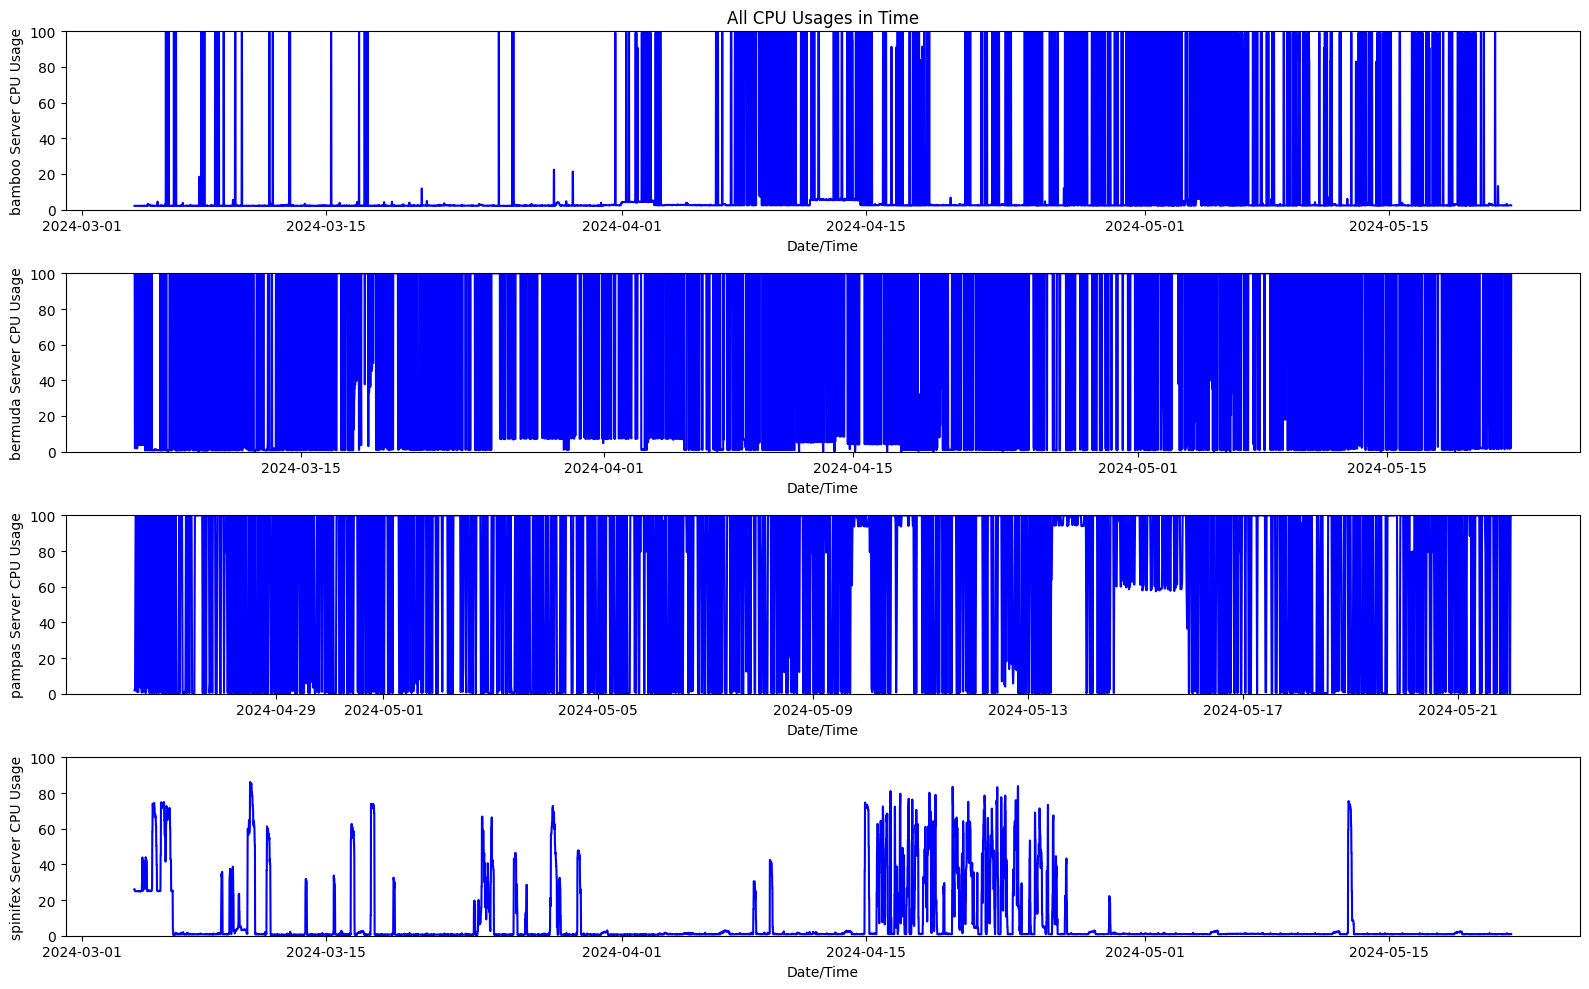

In [499]:
# server_names = {0: 'bamboo', 1: 'bermuda', 2: 'capsim', 3: 'messiaen', 4: 'pampas', 5: 'saintsaens', 6: 'spinifex', 7: 'widor'}
server_names = {0: 'bamboo', 1: 'bermuda', 2: 'pampas', 3: 'spinifex'}

fig, ax = plt.subplots(4, figsize=(16, 10))
for i in range(len(server_names)):
    ax[i].plot(eval(server_names[i])['now'], eval(server_names[i])['cpu.total'], color='b', linestyle='-')
    ax[i].set_xlabel('Date/Time')
    ax[i].set_ylabel(server_names[i] + ' Server CPU Usage')
    ax[i].set_ylim(0, 100)
ax[0].set_title("All CPU Usages in Time")
plt.tight_layout()
plt.show()

### Obtain Correlation Coefficients
In order to obtain a relatively reliable correlation coefficient, it is pertinent to average the CPU usages over the same sampling time as the power consumption. All samples have been taken approximately 15 minutes apart from each other: this has been empirically determined.

bamboo: 
-0.11142857441820049
-0.1709908683626398
bermuda: 
-0.048934919258287544
-0.1994625307275029
pampas: 
0.21728615632861284
0.1421744494524096
spinifex: 
0.13140451723647703
0.08466067800588767


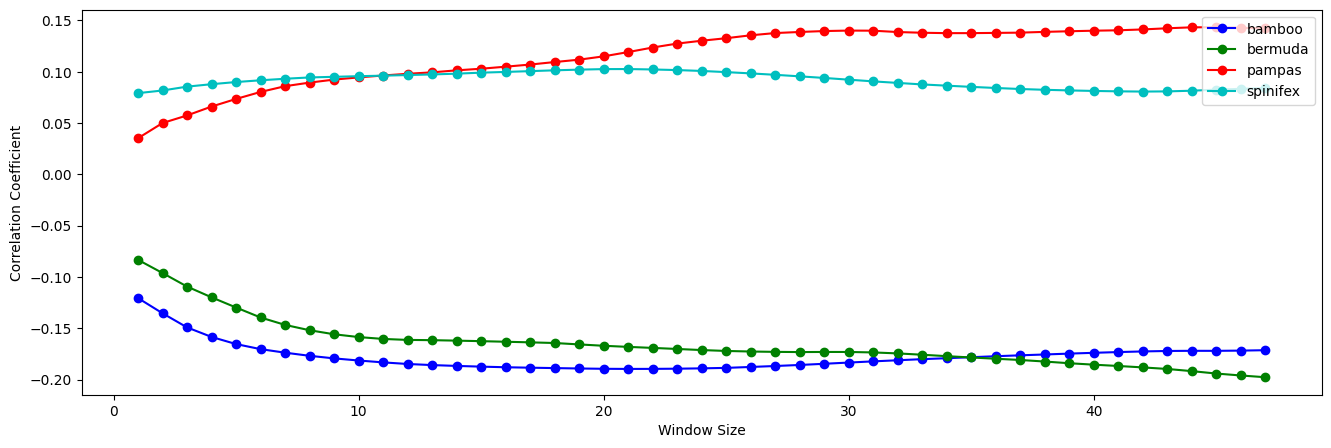

In [500]:
for name in server_names.values():
    eval(name)['cpu.av'] = eval(name)['cpu.total'].rolling(window=24*2).mean()
    print(name+": ")
    print(eval(name)['cpu.av'].corr(dl3[HEADER]))
    print(eval(name)['cpu.av'].corr(dl1[HEADER]))

# maxwindow = int(min([len(eval(name)) for name in server_names.values()])/2)
maxwindow = 24*2
step = 1
plt.figure(figsize=(16, 5))
for i in range(4):
    plt.plot(range(0, maxwindow, step), 
               [eval(server_names[i])['cpu.total'].rolling(window=j).mean().corr(dl1[HEADER]) for j in range(0, maxwindow, step)],
               color=colors[i], linestyle='-', marker='o', label=server_names[i])
plt.xlabel("Window Size")
plt.ylabel("Correlation Coefficient")
plt.legend(loc='upper right')
# plt.xticks(range(0, maxwindow, step), [str(k) for k in range(0, maxwindow, step)])
plt.show()

## 4. Frequency Analysis

A possible idea could be to do an FFT: as we know the sample size is 30 mins, we can get an accurate reading of the frequency of the current, up to a precision of 1 hour<sup>-1</sup>.

It is interesting to remove the first element of the FFT, as this essentially removes the constant component. We are now left with only the varying parts

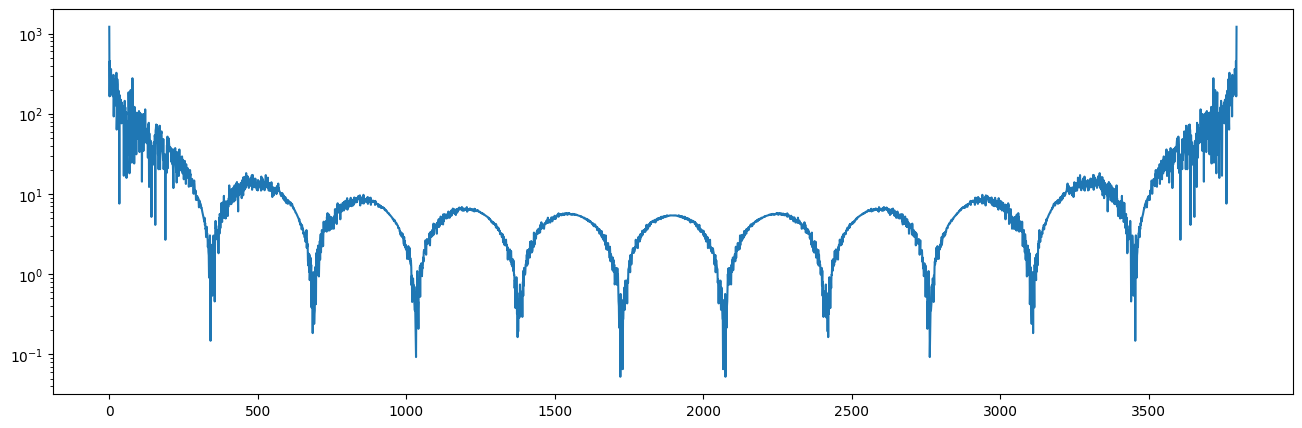

In [526]:
dl1[HEADER + " Av Daily"] = dl1[HEADER].rolling(window=12).mean()
dl1_fft = sp.fft.fft(np.array(dl1[HEADER + " Av Daily"].fillna(0.0)))[1:] # obtain FFT, remove constant term

# plot real part
plt.figure(figsize=(16, 5))
plt.plot(np.abs(dl1_fft))
# plt.xlim([0, 2*24*7])
# plt.vlines(x=range(0, 2*24*7, 24), ymin=0, ymax=5000, colors='r')
plt.yscale('log')
plt.show()